In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.dates as mdates

# 한글 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic)
import platform
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

In [49]:
# 1. 데이터 로드
try:
    df_gap = pd.read_csv('new_data/(사용액)decoupling_results.csv', encoding='utf-8-sig')
    df_loan = pd.read_csv('전처리/전처리_가계대출.csv', encoding='utf-8')
    df_rate = pd.read_csv('전처리/전처리_대출금리.csv', encoding='utf-8')
    print("데이터 로드 완료")
except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")

데이터 로드 완료


In [50]:
# 전처리: 날짜 인덱스 설정
# 디커플링 지수 (Gap)
df_gap['date'] = pd.to_datetime(df_gap['date'])
df_gap = df_gap.set_index('date').sort_index()

In [51]:
# 가계대출 잔액 (Household Loan)
df_loan['date'] = pd.to_datetime(df_loan['date'])
df_loan = df_loan.set_index('date').sort_index()

In [52]:
# 대출금리 (Interest Rate)
df_rate['date'] = pd.to_datetime(df_rate['date'])
df_rate = df_rate.set_index('date').sort_index()

In [53]:
# 데이터 병합 (Inner Join)
# 금리 데이터에서 '가계대출' 컬럼만 추출 (가계대출 평균 금리)
rate_col_name = [col for col in df_rate.columns if '가계대출' in col][0] 

df = df_gap[['gap']].join(df_loan[['hh_loan']], how='inner')
df = df.join(df_rate[[rate_col_name]], how='inner')
df = df.rename(columns={rate_col_name: 'hh_rate'})

In [54]:
# 파생변수 생성: 이자 부담 지수 (Interest Burden Index)
# 공식: 대출잔액 * (대출금리 / 100) -> 월별 이자 부담 규모 추정치
df['interest_burden'] = df['hh_loan'] * (df['hh_rate'] / 100)

In [55]:
# 통계 분석: 상관관계 및 P-value 계산 ---
# 전체 기간에 대한 시차 상관관계 (Cross-Correlation)
print("\n=== [가설 3] 자산 버블(Gap)과 이자 부담(Burden)의 시차 상관관계 ===")
print("(Gap이 변하고 나서, Burden이 어떻게 변하는가?)")
lags = [0, 6, 12, 18, 24] # 개월 수

results = []
for lag in lags:
    # Gap(t) vs Burden(t+lag) -> Gap이 선행지표
    # 데이터를 lag만큼 shift하여 비교
    temp_df = pd.DataFrame({
        'gap': df['gap'],
        'burden_lag': df['interest_burden'].shift(-lag) # Burden을 미래 시점으로 당겨옴 (Gap 기준)
    }).dropna()
    
    if len(temp_df) > 0:
        corr, p_val = pearsonr(temp_df['gap'], temp_df['burden_lag'])
        results.append({'Lag(개월)': lag, '상관계수(r)': corr, 'P-value': p_val})


=== [가설 3] 자산 버블(Gap)과 이자 부담(Burden)의 시차 상관관계 ===
(Gap이 변하고 나서, Burden이 어떻게 변하는가?)


In [56]:
# 결과 출력 (DataFrame으로 깔끔하게)
df_results = pd.DataFrame(results)
print(df_results)
print("-" * 60)

   Lag(개월)   상관계수(r)   P-value
0        0 -0.009257  0.892660
1        6 -0.068553  0.324000
2       12 -0.046970  0.505763
3       18 -0.027645  0.699774
4       24 -0.006143  0.932790
------------------------------------------------------------


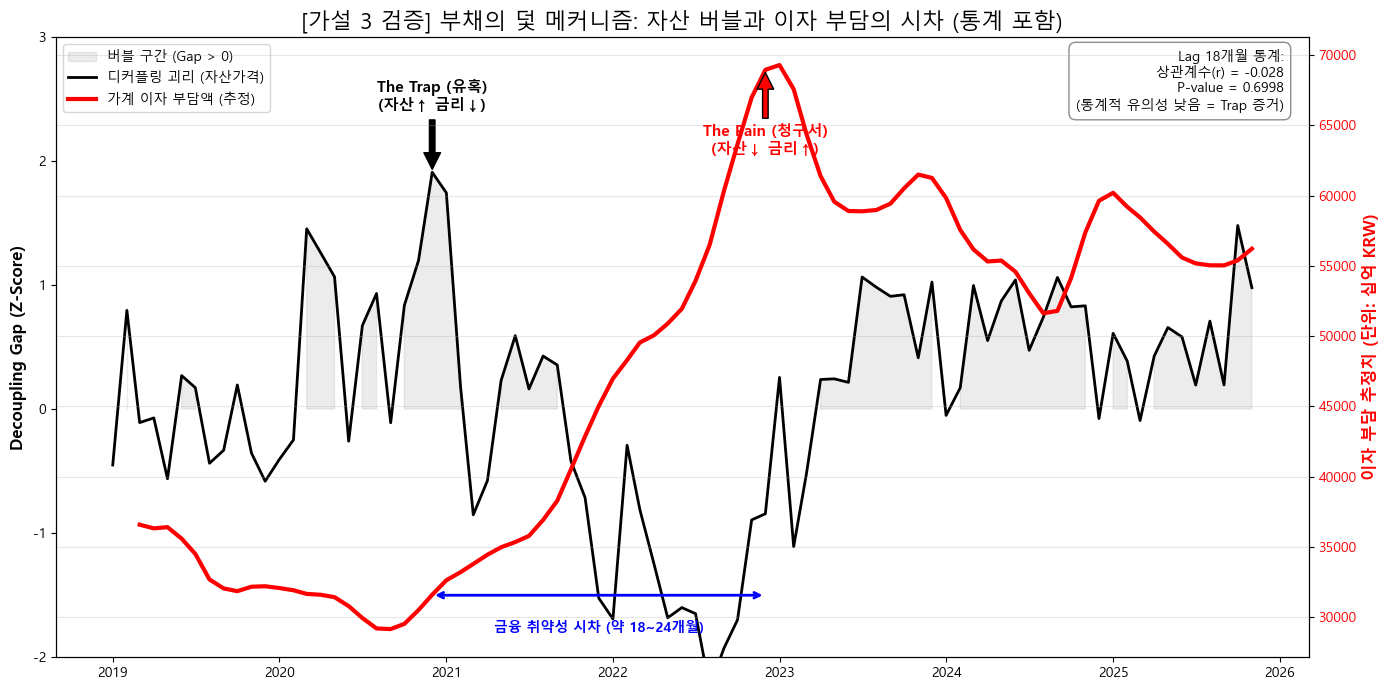

In [62]:
# 시각화: '부채의 덫' 메커니즘 (The Debt Trap) ---
# 가장 극적인 변화를 보여주는 2019년 이후 데이터 집중 분석
df_focus = df.loc['2019-01-01':]

fig, ax1 = plt.subplots(figsize=(14, 7))

# 배경: 자산 버블 구간 (Gap > 0인 구간 회색 처리)
ax1.fill_between(df_focus.index, df_focus['gap'], 0, where=(df_focus['gap']>0), 
                 color='gray', alpha=0.15, label='버블 구간 (Gap > 0)')

# 왼쪽 축: 디커플링 괴리 (검은색 실선) - 원인/유혹
ax1.plot(df_focus.index, df_focus['gap'], color='black', linewidth=2, label='디커플링 괴리 (자산가격)')
ax1.set_ylabel('Decoupling Gap (Z-Score)', fontsize=12, fontweight='bold')
ax1.set_ylim(-2, 3) # Y축 범위 조정

# 오른쪽 축: 가계 이자 부담 (빨간색 실선) - 결과/고통
# 추세를 부드럽게 보기 위해 3개월 이동평균 적용
burden_smooth = df_focus['interest_burden'].rolling(3).mean()
ax2 = ax1.twinx()
ax2.plot(df_focus.index, burden_smooth, color='red', linewidth=3, label='가계 이자 부담액 (추정)')
ax2.set_ylabel('이자 부담 추정치 (단위: 십억 KRW)', color='red', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')

# 핵심 주석(Annotation) 달기: 유혹과 고통의 시차
# 정점(Peak) 찾기
peak_gap_idx = df_focus['gap'].idxmax()           # 자산 버블 정점
peak_pain_idx = df_focus['interest_burden'].idxmax() # 이자 부담 정점

# 유혹의 시기 (The Trap)
ax1.annotate('The Trap (유혹)\n(자산↑ 금리↓)', 
             xy=(peak_gap_idx, df_focus.loc[peak_gap_idx, 'gap']), 
             xytext=(peak_gap_idx, df_focus.loc[peak_gap_idx, 'gap'] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', fontsize=11, fontweight='bold')

# 고통의 시기 (The Pain)
ax2.annotate('The Pain (청구서)\n(자산↓ 금리↑)', 
             xy=(peak_pain_idx, burden_smooth.loc[peak_pain_idx]), 
             xytext=(peak_pain_idx, burden_smooth.loc[peak_pain_idx] - 6000), 
             arrowprops=dict(facecolor='red', shrink=0.05),
             ha='center', color='red', fontsize=11, fontweight='bold')

# 시차 화살표 (Time Lag)
# Y축 좌표를 적절히 설정 (그래프 하단부)
arrow_y_pos = -1.5
ax1.annotate('', xy=(peak_pain_idx, arrow_y_pos), xytext=(peak_gap_idx, arrow_y_pos),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))

# 텍스트 위치: 화살표 중간
mid_date = peak_gap_idx + (peak_pain_idx - peak_gap_idx)/2
ax1.text(mid_date, arrow_y_pos - 0.3, 
         '금융 취약성 시차 (약 18~24개월)', color='blue', ha='center', fontweight='bold')

# 통계 결과 박스 (Lag 18개월 기준)
# 표에 있는 결과 중 18개월 Lag 값을 가져옴
stat_18 = df_results.loc[df_results['Lag(개월)'] == 18].iloc[0]
stat_text = f"Lag 18개월 통계:\n상관계수(r) = {stat_18['상관계수(r)']:.3f}\nP-value = {stat_18['P-value']:.4f}\n(통계적 유의성 낮음 = Trap 증거)"

# 그래프 우측 상단에 표시
ax1.text(0.98, 0.98, stat_text, transform=ax1.transAxes, 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'), 
         ha='right', va='top')

plt.title('[가설 3 검증] 부채의 덫 메커니즘: 자산 버블과 이자 부담의 시차 (통계 포함)', fontsize=16)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

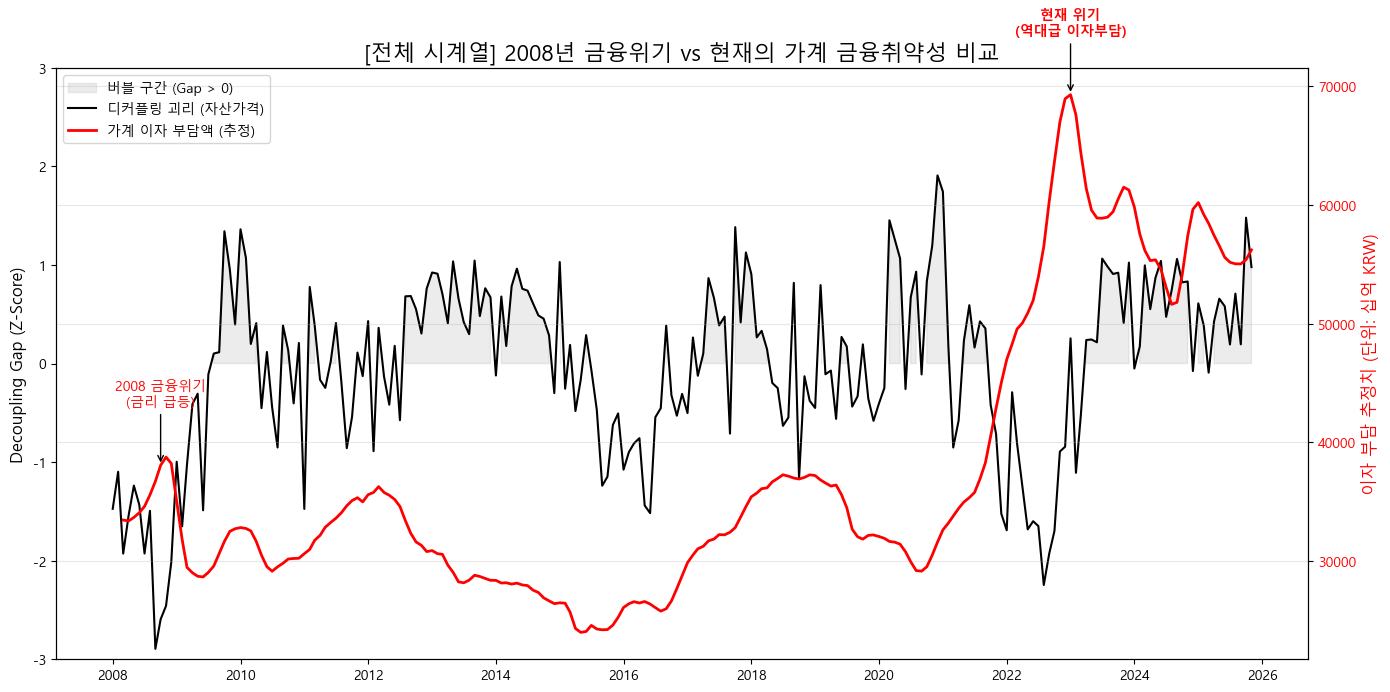

In [58]:
# --- 전체 기간(2008~2025) 분석 ---
# 날짜 필터링을 하지 않고 전체 df 사용
df_full = df.copy() 

fig, ax1 = plt.subplots(figsize=(14, 7))

# 배경: 자산 버블 구간 (Gap > 0)
ax1.fill_between(df_full.index, df_full['gap'], 0, where=(df_full['gap']>0), 
                 color='gray', alpha=0.15, label='버블 구간 (Gap > 0)')

# 왼쪽 축: 디커플링 괴리 (검은색)
ax1.plot(df_full.index, df_full['gap'], color='black', linewidth=1.5, label='디커플링 괴리 (자산가격)')
ax1.set_ylabel('Decoupling Gap (Z-Score)', fontsize=12)
ax1.set_ylim(-3, 3)

# 오른쪽 축: 가계 이자 부담 (빨간색)
# 전체 기간이므로 변동성이 클 수 있어 3개월 이동평균 적용
burden_smooth = df_full['interest_burden'].rolling(3).mean()
ax2 = ax1.twinx()
ax2.plot(df_full.index, burden_smooth, color='red', linewidth=2, label='가계 이자 부담액 (추정)')
ax2.set_ylabel('이자 부담 추정치 (단위: 십억 KRW)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# 주요 사건 주석 달기 (2008년 vs 2024년 비교)
# 2008 금융위기 시점
ax2.annotate('2008 금융위기\n(금리 급등)', 
             xy=(pd.Timestamp('2008-10-01'), burden_smooth.loc['2008-10-01']), 
             xytext=(pd.Timestamp('2008-10-01'), burden_smooth.loc['2008-10-01'] + 5000),
             arrowprops=dict(facecolor='red', arrowstyle='->'), ha='center', color='red')

# 2024 최근 위기 시점 (최고점 찾기)
peak_recent = df_full.loc['2023-01-01':]['interest_burden'].idxmax()
ax2.annotate('현재 위기\n(역대급 이자부담)', 
             xy=(peak_recent, burden_smooth.loc[peak_recent]), 
             xytext=(peak_recent, burden_smooth.loc[peak_recent] + 5000),
             arrowprops=dict(facecolor='red', arrowstyle='->'), ha='center', color='red', fontweight='bold')

plt.title('[전체 시계열] 2008년 금융위기 vs 현재의 가계 금융취약성 비교', fontsize=16)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()